#### Student Loan Forgiveness

In [1]:
import sys
print(sys.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


In [29]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [30]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.functions import col

In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
%%time
twitter = spark.read.parquet('gs://chen26-bdp/original_data')

CPU times: user 3.89 ms, sys: 4.59 ms, total: 8.47 ms
Wall time: 8.78 s


23/03/08 19:24:56 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
keywords = ['loan','biden','forgiveness']
#filter out rows that do not contain words in keywords
twitter = twitter.withColumn('lower', lower(col('text')))
filter_twitter = twitter.filter(col('lower').rlike('|'.join(keywords)))

twitter_eng = filter_twitter.filter(col('lang') == 'en')
from pyspark.sql import functions as F
from pyspark.sql import types as t
from pyspark.sql.types import ArrayType, IntegerType, BooleanType

eng_ord=F.udf(lambda x: [ord(a) for a in x],t.ArrayType(IntegerType()))

def english_filter(x):
    for index in range(len(x)):
        if x[index] > 128:
            return False
        else:
            return True

filter_udf = F.udf(english_filter, BooleanType())
loan_tweets = twitter_eng.filter(filter_udf(eng_ord('text')) == True)

In [7]:
loan_tweets.count()

1031389

In [8]:
from pyspark.sql.functions import from_unixtime, date_format
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
tweets_day = loan_tweets.select('id', 'created_at')
tweets_day = tweets_day.withColumn("timestamp_unix", from_unixtime(unix_timestamp("created_at", "EEE MMM dd HH:mm:ss Z yyyy")))
tweets_day = tweets_day.withColumn("date", date_format("timestamp_unix", "yyyy-MM-dd"))
tweets_by_day = tweets_day.drop('created_at', 'timestamp_unix')
total_by_day = tweets_by_day.groupby('date').agg(count('*').alias('daily_tweets'))
day_total = total_by_day.orderBy('date', ascending = True)
day = day_total.toPandas()

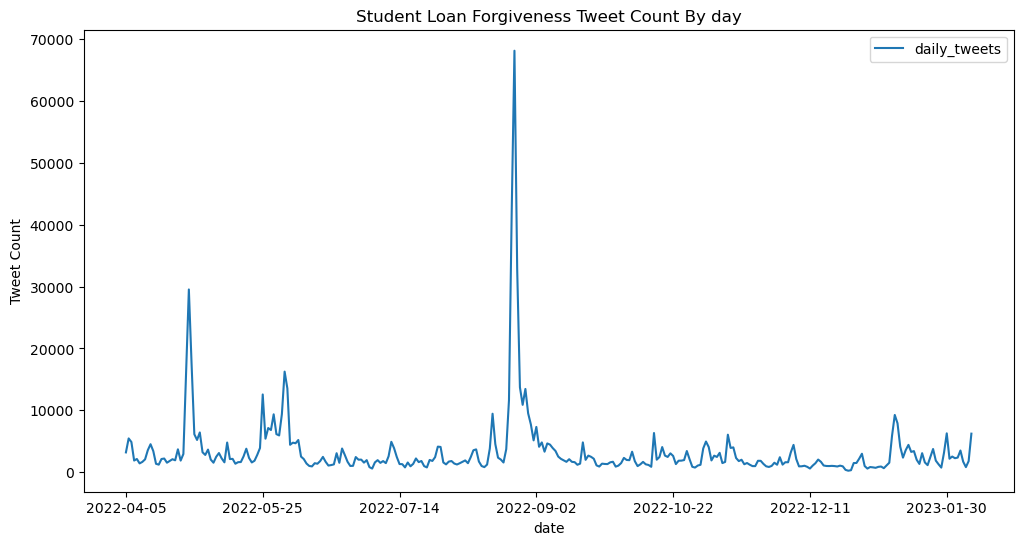

In [12]:
day.plot(kind="line",x= 'date', y="daily_tweets", figsize=(12, 6))
plt.ylabel("Tweet Count")
plt.title('Student Loan Forgiveness Tweet Count By day')
plt.show()

In [10]:
month_total = day_total.withColumn('month', month(col('date')))
month_total_t = month_total.groupby('month').agg(sum('daily_tweets').alias('monthly_tweets'))
month = month_total_t.toPandas()

In [13]:
month

,month,monthly_tweets
0,12,43327
1,1,83409
2,6,100325
3,5,120567
4,9,81236
5,4,126768
6,8,264982
7,7,59386
8,10,63295
9,11,66786


In [17]:
months = ['4','5','6','7','8','9','10','11','12','1','2']
count = [126768, 120567,100325, 59386, 264982, 81236, 63295, 66786, 43327, 83409, 21308]

tweet_month = pd.DataFrame({'Months': months, 'tweet_count': count})

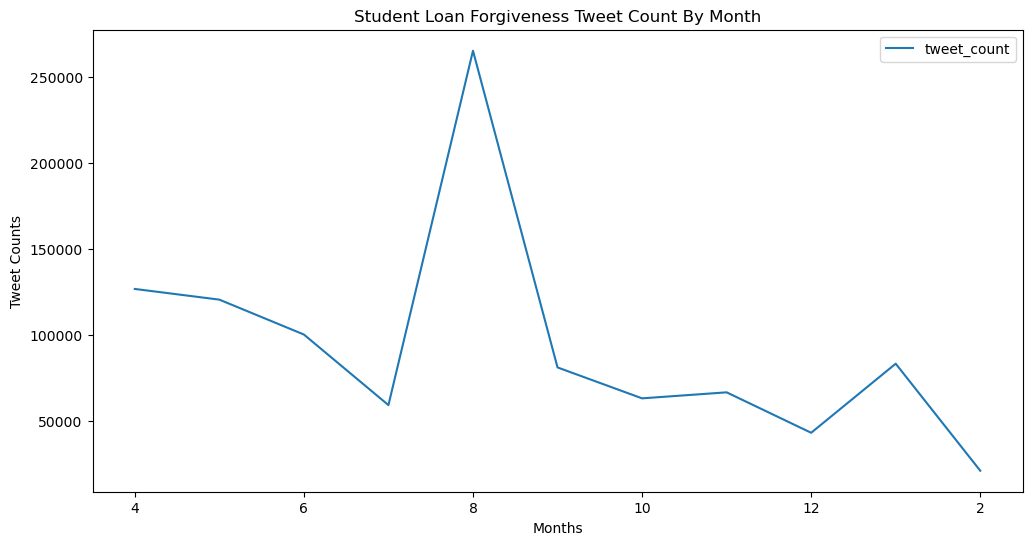

In [18]:
tweet_month.plot(kind="line",x= 'Months', y="tweet_count", figsize=(12, 6))
plt.ylabel("Tweet Counts")
plt.xlabel('Months')
plt.title('Student Loan Forgiveness Tweet Count By Month')
plt.show()

In [23]:
dt = loan_tweets.select([loan_tweets.created_at,
                    loan_tweets.id_str.alias('tweet_id'),
                    loan_tweets.user['id'].alias('user_id'), 
                    loan_tweets.user['screen_name'].alias('user_name'),
                    loan_tweets.user['verified'].alias('verified'),
                    loan_tweets.user['followers_count'].alias('followers_count'),
                    loan_tweets.user['description'].alias('user_description'),
                    loan_tweets.user['location'].alias('user_location'),
                    loan_tweets.text,
                    loan_tweets.retweeted_status.retweet_count.alias('rt_count'),
                    loan_tweets.retweeted_status.favorite_count.alias('rt_fav'),
                    loan_tweets.retweeted_status.quote_count.alias('rt_quo'),
                    loan_tweets.retweeted_status.retweeted.alias('retweet'),
                    loan_tweets.retweeted_status.user['name'].alias('rt_user_name')])


In [31]:
from pyspark.sql.functions import month
dt_loc = dt.filter(col('user_location').isNotNull())
dt_loc = dt_loc.select('tweet_id', 'created_at', 'user_location')
dt_loc = dt_loc.withColumn("timestamp_unix", from_unixtime(unix_timestamp("created_at", "EEE MMM dd HH:mm:ss Z yyyy")))
dt_loc = dt_loc.withColumn("date", date_format("timestamp_unix", "yyyy-MM-dd"))
dt_loc = dt_loc.drop('created_at', 'timestamp_unix')
dt_loc = dt_loc.withColumn('month', month('date'))
dt9 = dt_loc.filter(col('month')==9)
dt9 = dt9.withColumn('loc', split(dt9.user_location, ", ").getItem(0))
dt9 = dt9.filter(col("user_location").like("%,%"))
dt9_count = dt9.groupby('loc').agg(count('*').alias('num_tweets'))
dt9_desc = dt9_count.orderBy(col('num_tweets').desc()).limit(50)

In [33]:
df9 = dt9_desc.toPandas()

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


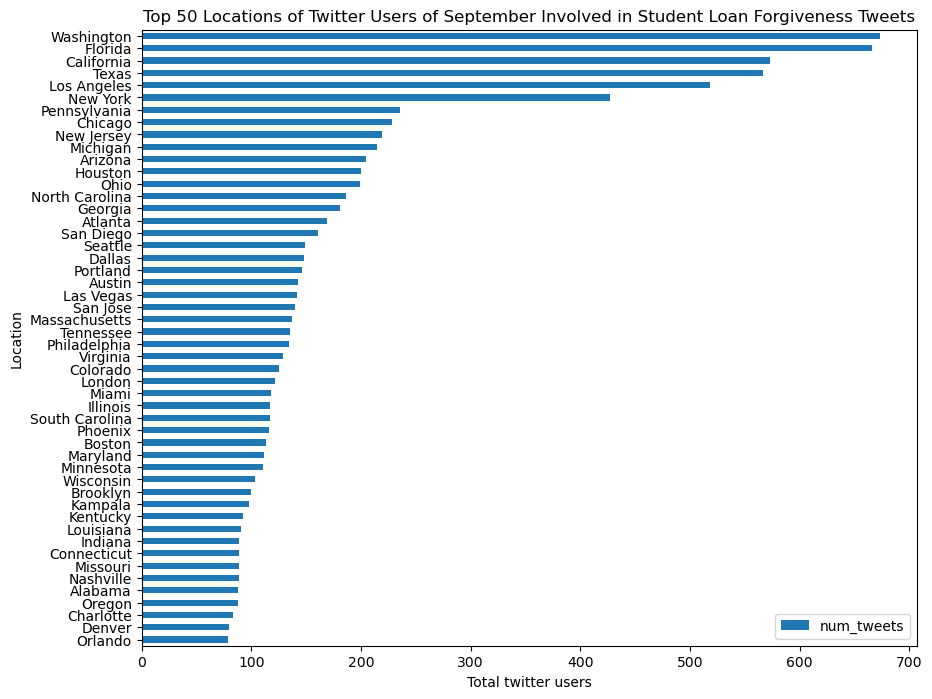

In [35]:
ax = df9.plot(x ='loc',y='num_tweets', kind='barh', figsize = (10, 8))

ax.set_ylabel('Location')
ax.set_xlabel('Total twitter users')
ax.set_title('Top 50 Locations of Twitter Users of September Involved in Student Loan Forgiveness Tweets')
ax.invert_yaxis()

# show the plot
plt.show()

In [36]:
dt8 = dt_loc.filter(col('month')==8)
dt8 = dt8.withColumn('loc', split(dt8.user_location, ", ").getItem(0))
dt8 = dt8.filter(col("user_location").like("%,%"))
dt8_count = dt8.groupby('loc').agg(count('*').alias('num_tweets'))
dt8_desc = dt8_count.orderBy(col('num_tweets').desc()).limit(50)
df8 = dt8_desc.toPandas()

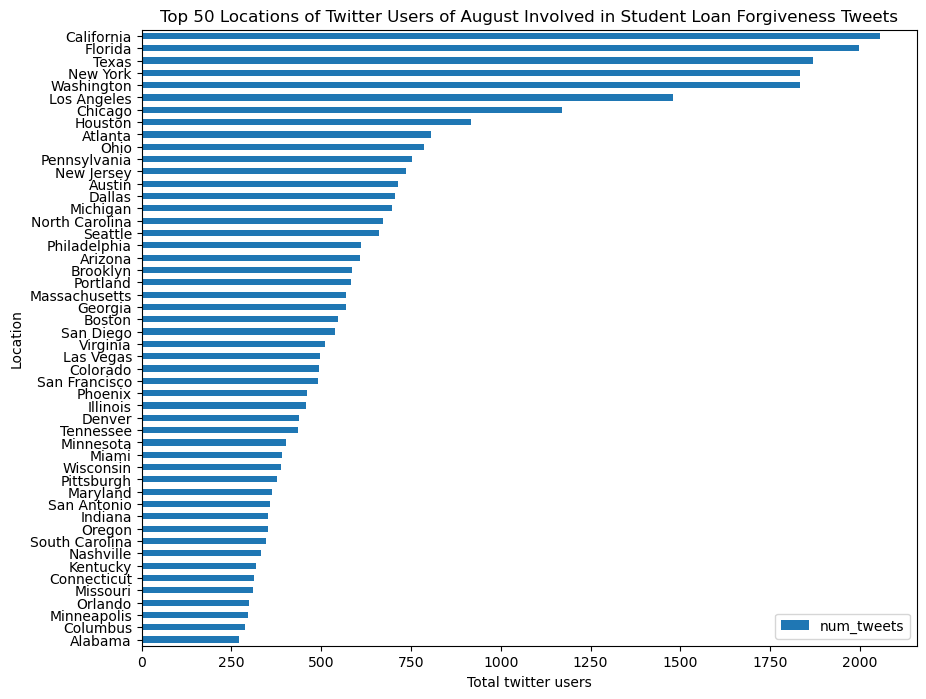

In [38]:
ax = df8.plot(x ='loc',y='num_tweets', kind='barh', figsize = (10, 8))

ax.set_ylabel('Location')
ax.set_xlabel('Total twitter users')
ax.set_title('Top 50 Locations of Twitter Users of August Involved in Student Loan Forgiveness Tweets')
ax.invert_yaxis()

# show the plot
plt.show()

In [41]:
keywords = ['college', 'high', 'university', 'students'
            , 'public', 'private', 'secondary', 'primary', 'education', 'undergraduate','graduate']
#filter out rows that do not contain words in keywords
twitter = twitter.withColumn('lower', lower(col('text')))
filter_twitter = twitter.filter(col('lower').rlike('|'.join(keywords)))

twitter_eng = filter_twitter.filter(col('lang') == 'en')
from pyspark.sql import functions as F
from pyspark.sql import types as t
from pyspark.sql.types import ArrayType, IntegerType, BooleanType

eng_ord=F.udf(lambda x: [ord(a) for a in x],t.ArrayType(IntegerType()))

def english_filter(x):
    for index in range(len(x)):
        if x[index] > 128:
            return False
        else:
            return True

filter_udf = F.udf(english_filter, BooleanType())
tweets = twitter_eng.filter(filter_udf(eng_ord('text')) == True)

t = tweets.select([tweets.created_at,
                    tweets.id_str.alias('tweet_id'),
                    tweets.user['id'].alias('user_id'), 
                    tweets.user['screen_name'].alias('user_name'),
                    tweets.user['verified'].alias('verified'),
                    tweets.user['followers_count'].alias('followers_count'),
                    tweets.user['description'].alias('user_description'),
                    tweets.user['location'].alias('user_location'),
                    tweets.text,
                    tweets.retweeted_status.retweet_count.alias('rt_count'),
                    tweets.retweeted_status.favorite_count.alias('rt_fav'),
                    tweets.retweeted_status.quote_count.alias('rt_quo'),
                    tweets.retweeted_status.retweeted.alias('retweet'),
                    tweets.retweeted_status.user['name'].alias('rt_user_name')])

In [ ]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
tdt = t.filter(col('user_location').isNotNull())
tdt = tdt.select('tweet_id', 'created_at', 'user_location')
tdt = tdt.withColumn("timestamp_unix", from_unixtime(unix_timestamp("created_at", "EEE MMM dd HH:mm:ss Z yyyy")))
tdt = tdt.withColumn("date", date_format("timestamp_unix", "yyyy-MM-dd"))
tdt = tdt.withColumn('month', month('date'))
tdt9 = tdt.filter(col('month')==9)
tdt9 = tdt9.withColumn('loc', split(tdt9.user_location, ", ").getItem(0))
tdt9 = tdt9.filter(col("user_location").like("%,%"))
tdt_count = tdt9.groupby('loc').agg(count('*').alias('num_tweets'))
tdt_desc = tdt_count.orderBy(col('num_tweets').desc()).limit(50)
tdt_df = tdt_desc.toPandas()

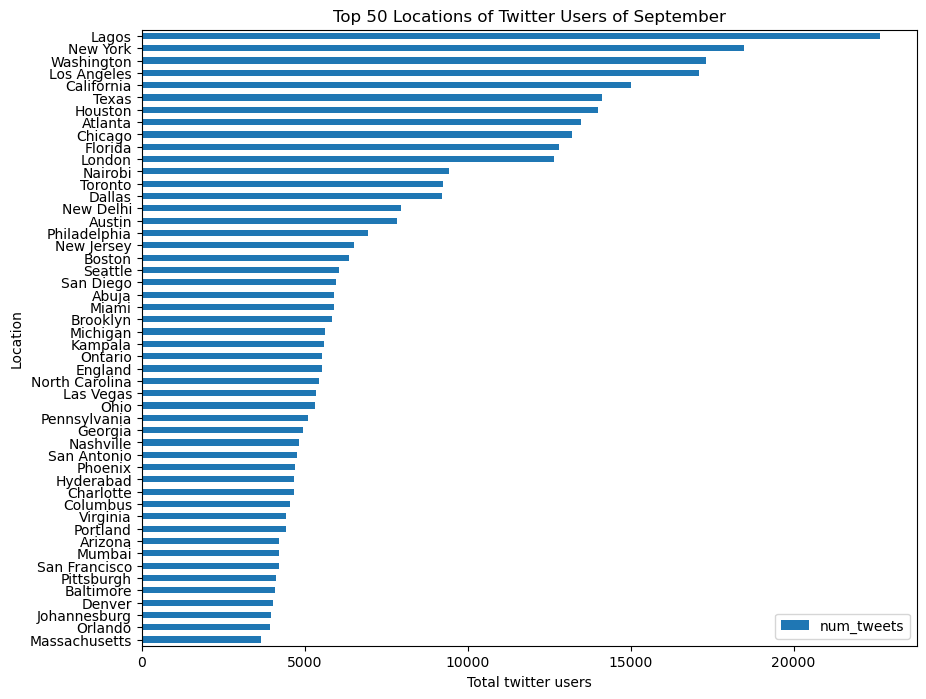

In [43]:
ax = tdt_df.plot(x ='loc',y='num_tweets', kind='barh', figsize = (10, 8))

ax.set_ylabel('Location')
ax.set_xlabel('Total twitter users')
ax.set_title('Top 50 Locations of Twitter Users of September')
ax.invert_yaxis()

# show the plot
plt.show()

In [44]:
tdt8 = tdt.filter(col('month')== 8)
tdt8 = tdt8.withColumn('loc', split(tdt8.user_location, ", ").getItem(0))
tdt8 = tdt8.filter(col("user_location").like("%,%"))
tdt_count = tdt8.groupby('loc').agg(count('*').alias('num_tweets'))
tdt_desc = tdt_count.orderBy(col('num_tweets').desc()).limit(50)
tdt_df8 = tdt_desc.toPandas()

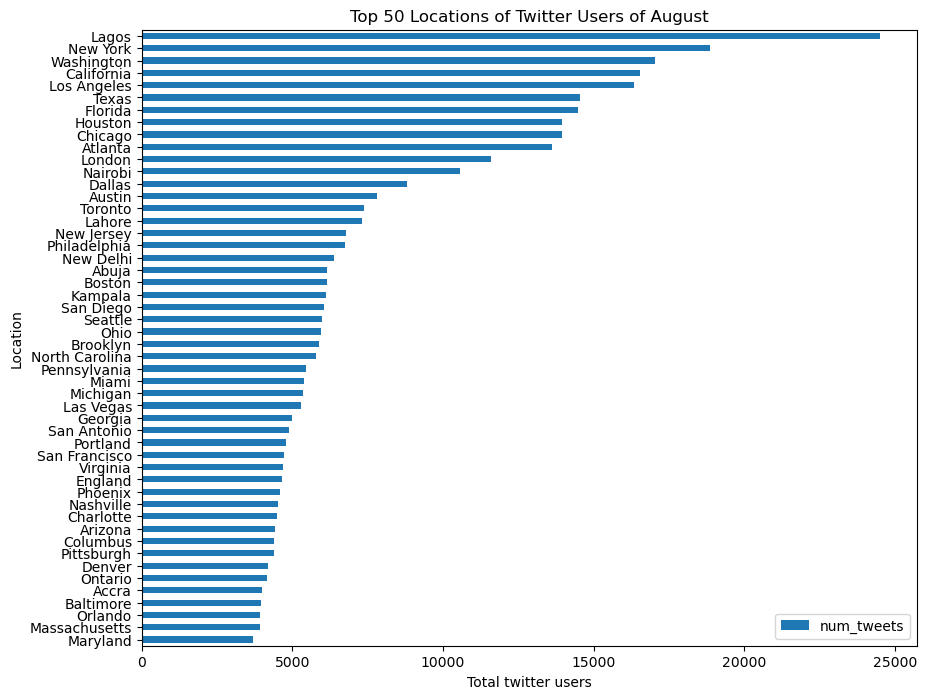

In [46]:
ax = tdt_df8.plot(x ='loc',y='num_tweets', kind='barh', figsize = (10, 8))

ax.set_ylabel('Location')
ax.set_xlabel('Total twitter users')
ax.set_title('Top 50 Locations of Twitter Users of August')
ax.invert_yaxis()

# show the plot
plt.show()